In [1]:
import sys
sys.path.append('.')

%load_ext autoreload
%autoreload 2

In [2]:
import pyro

pyro.set_rng_seed(100)

In [3]:
from IPython.display import Code, display
import numpy as np
import pyro.distributions as dist

from src.mcmc import dataset
from src.mcmc import infer
from src.mcmc import model
from src.mcmc import vis

### Metropolis Hastings Sampler
https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a

Implement the Metropolis Hastings Sampler based on the description provided in the link above. Use the code provided below to evaluate the correctnes of implementation.
In the file `src/mcmc/mhs.py` you can find an interface compatible with Pyro. Use it.

In [4]:
display(Code('src/mcmc/mhs.py'))

from collections import defaultdict
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pyro
import torch
from pyro.infer.mcmc import mcmc_kernel
from pyro.infer.mcmc.util import initialize_model


class MetropolisHastings(mcmc_kernel.MCMCKernel):
    """Implementation of Metropolis Hastings sampler for MCMC."""

    def __init__(self, model, proposal_dist, priors):
        """Inits MetropolisHastings.

        :param model: Probabilistic model to estimate (likelihood).
        :param proposal_dist: Distribution to generate next parameter value.
        :param priors: Prior distribution over parameter space.
        """
        self.model = model
        self._proposal_dist = proposal_dist
        self._priors = priors

        self._model_args = None
        self._model_kwargs = None

        self._initial_params = None

        self._step = 0
        self._warmup_steps = None

        self._generated_samples = {
            'accepted': defaultdict(list),
            'rejected': defaultdict(list),
            'counts': {
                'accepted': 0,
                'rejected': 0,
            }
        }

    @property
    def initial_params(self):
        return self._initial_params

    @initial_params.setter
    def initial_params(self, params):
        self._initial_params = params

    def logging(self):
        """Provides statistics for progress bar."""
        return {
            '#accepted': self._generated_samples['counts']['accepted'],
            '#rejected': self._generated_samples['counts']['rejected'],
        }

    def setup(self, warmup_steps, *args, **kwargs):
        """Sets up the sampler."""
        self._warmup_steps = warmup_steps

        init_params, _, _, _ = initialize_model(
            self.model, args, kwargs,
        )
        if self._initial_params is None:
            self._initial_params = init_params

        self._model_args = args
        self._model_kwargs = kwargs

    def _next_parameters_proposal(
            self,
            curr_params: Dict[str, torch.Tensor]
    ) -> Dict[str, torch.Tensor]:
        """Samples new parameters from the proposal distribution.

        Use `pyro.sample` and include current step in the sample name,
        eg. `c_0`, `c_1`...

        :param curr_params: Current parameter values.
        :return: New  parameter values.
        """
        # === Implement this
        with_step = lambda p_key: f'{p_key}_{self._step}'
        sample_p = lambda p_key, p_current: pyro.sample(with_step(p_key), self._proposal_dist(p_current))
        return {k: sample_p(k, v) for (k, v) in curr_params.items()}
        # ==================

    def _get_log_likelihood(self, params):
        """Calculates the log-likelihood of the provided params.

        Use `pyro.condition` and `pyro.poutine.trace`.
        """
        # === Implement this
        conditioned_model = pyro.condition(self.model, data=params)
        trace = pyro.poutine.trace(conditioned_model).get_trace(*self._model_args, **self._model_kwargs)
        return trace.log_prob_sum()
        # ==================

    def _get_log_priors(self, params):
        """Calculates log-prob of prior distribution for the provided params."""
        vals = [self._priors[pname](pval) for pname, pval in params.items()]
        return torch.tensor(vals).log().sum()

    def _should_accept(self, curr_lp, new_lp):
        """Decides whether to accept or reject the new params configuration."""
        # === Implement this
        if new_lp > curr_lp:
            return True
        else:
            accept = np.random.uniform(0, 1)
        return accept < (new_lp - curr_lp).exp().item()
        # ==================

    def sample(self, params):
        """Returns new params configuration given current.

        The man body of the Metropolis Hastings sampling algorithm.
        """
        # === Implement this
        new_params = self._next_parameters_proposal(curr_params=params)
        curr_

In [5]:
from src.mcmc import mhs

## Generate data

In [6]:
ds = dataset.generate_dataset(2_000, train_size=0.6)

## Estimate model parameters 

In [7]:
posteriors = {}

In [11]:
mh_kernels = {
    ic: mhs.MetropolisHastings(
        model=model.speedometer_model,
        proposal_dist=lambda mean: dist.Normal(mean, 1.),
        priors={
            'c': lambda v: 1. if v > 0 else 0.,
            'std': lambda v: 1. if v > 0 else 0.,
        },
    )
    for ic in (0, 1)
}
         

posteriors['MetropolisHastings'] = {
    ic: infer.run_mcmc(
        kernel=mh_kernels[ic],
        model_args=(ds['train'][ic]['speed_limit'], ic, ds['train'][ic]['measurement']),
        num_samples=1_000,
        warmup_steps=200,
    )
    for ic in (0, 1)
}

posteriors['MetropolisHastings'][0].summary()
posteriors['MetropolisHastings'][1].summary()

Sample: 100%|██████████| 1200/1200 [00:02, 500.42it/s, #accepted=6, #rejected=1992]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.96      0.00      0.95      0.95      0.96       nan      2.77
       std     10.30      0.21     10.49     10.07     10.49       nan      2.77


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.75      0.00      0.75      0.75      0.75       nan      1.49
       std      4.78      0.23      4.98      4.47      4.98       nan      1.02



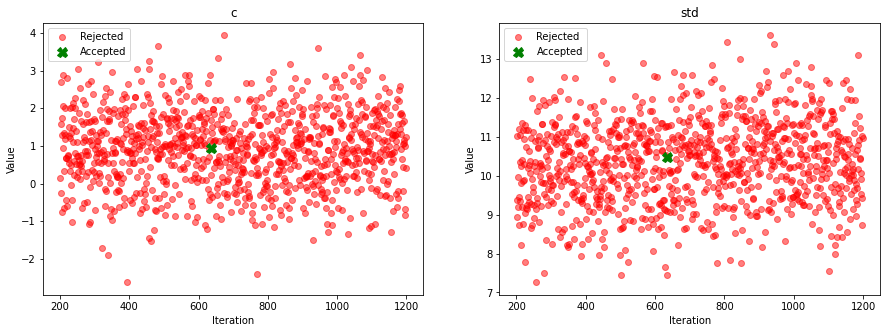

In [12]:
mhs.plot_accepted_rejected_samples(mh_kernels[0])

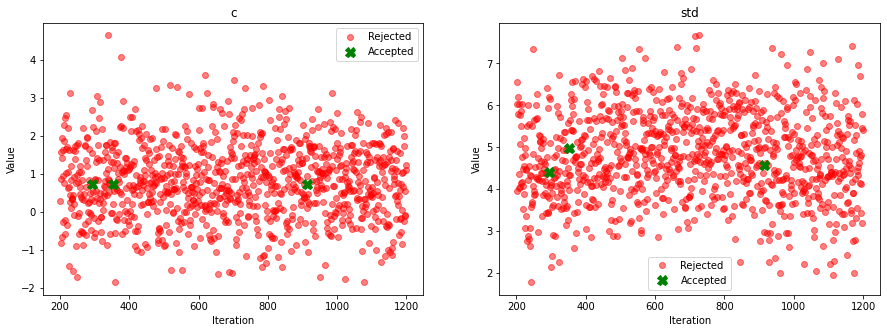

In [13]:
mhs.plot_accepted_rejected_samples(mh_kernels[1])

## Make predictors

In [14]:
from pyro.infer import Predictive

In [15]:
mcmc_predictive = {
    name: {
        ic: Predictive(
            lambda sl: model.speedometer_model(sl, ic),
            posterior_samples=infer.sample_mcmc(posteriors[name][ic]),
            return_sites=('measurement',)
        )
        for ic in (0, 1)
    }
    for name in ('MetropolisHastings',)
}

## Plot predictions and real samples

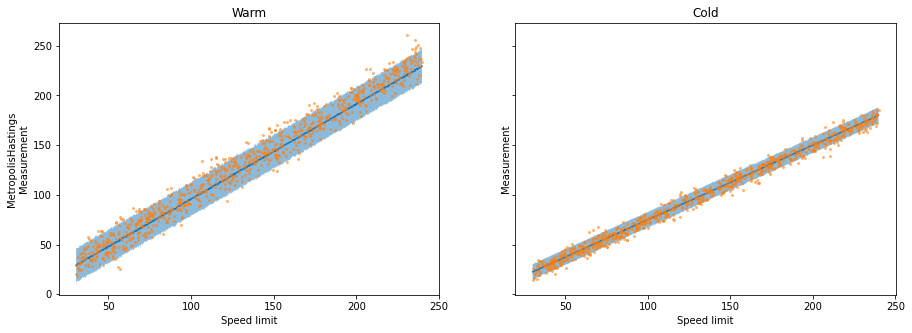

In [16]:
vis.plot_predictions(ds['test'], mcmc_predictive)